In [20]:


#dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, Model, utils, models, datasets
import numpy as np
# get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import pickle



image shape: (32, 32, 3)


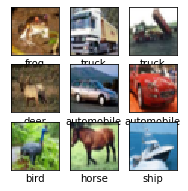

In [21]:


#download the fashion cifar10 data
fashion_mnist = keras.datasets.cifar10
(trainingData, trainingLabels), (testingData, testingLabels) = fashion_mnist.load_data()
classNames = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# download the fashioin mnist data
# fashion_mnist = keras.datasets.fashion_mnist
# (trainingData, trainingLabels), (testingData, testingLabels) = fashion_mnist.load_data()
# classNames = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#plot a few images
plt.figure(figsize=(3,3))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainingData[i], cmap=plt.cm.binary)
    plt.xlabel(classNames[trainingLabels[i][0]])
# plt.show()

print("image shape: %s"%str(trainingData[0].shape))



In [22]:

#preprocess data by rescaling to [0,1]
# trainingData = trainingData / 255.0
# testingData = testingData / 255.0

# #flatten the training data
# inputDimension = trainingData[0].shape[0]*trainingData[0].shape[1]
inputDimension = (32, 32, 3)
# inputDimension = (28, 28, 1)
# # trainingDataFlat = trainingData.copy()
# # trainingDataFlat = trainingData.reshape(-1,inputDimension)



In [23]:
def W_BN_Relu(previousLayer, filter_num, activation):

    # Does a convultion, then a batch norm, and then activates with 'relu'
    previousLayer = layers.Conv2D(filters=filter_num, kernel_size=(3,3), padding='same')(previousLayer)
    previousLayer = layers.BatchNormalization(axis=3)(previousLayer)
    previousLayer = layers.Activation(activation)(previousLayer)

    return previousLayer


In [24]:
def W_BN(previousLayer, filter_num):

    # Does a convultion, then a batch norm
    previousLayer = layers.Conv2D(filters=filter_num, kernel_size=(3,3), padding='same')(previousLayer)
    previousLayer = layers.BatchNormalization(axis=3)(previousLayer)

    return previousLayer

In [25]:
def shortcut_block(previousLayer, temp_layer, filter_num, activation):
    # convulation block (W -> BN -> Act -> W -> BN -> Act -> W -> BN ) + (W -> BN) -> act ==>

    # normal route
    previousLayer = W_BN_Relu(previousLayer, filter_num, activation)
    previousLayer = W_BN_Relu(previousLayer, filter_num, activation)
    previousLayer = W_BN(previousLayer, filter_num)

    # shortcut branch
    temp_layer = W_BN(temp_layer, filter_num)

    # concat the two branches
    previousLayer = layers.Concatenate()([previousLayer,temp_layer])

    return previousLayer, previousLayer # updates the temp_layer by sending a copy of the most updated previous layer to be used later


In [26]:
# building the resnet
# instantiate input layer
inputLayer = layers.Input(shape=inputDimension)
previousLayer = inputLayer

#calculate shape of the last layer
outputDimension = len(classNames)
activation = 'relu'

# convultion layer, batch norm, max pool
filter_num = 2
previousLayer = layers.Conv2D(filters=filter_num, kernel_size=(3,3), padding='same')(previousLayer)
previousLayer = layers.MaxPooling2D((2,2))(previousLayer)
temp_layer = previousLayer

previousLayer, temp_layer = shortcut_block(previousLayer, temp_layer, filter_num, activation)
previousLayer, temp_layer = shortcut_block(previousLayer, temp_layer, filter_num, activation)
filter_num *= 2
previousLayer = layers.MaxPool2D((2,2))(previousLayer)
temp_layer = previousLayer
previousLayer, temp_layer = shortcut_block(previousLayer, temp_layer, filter_num, activation)


# average pool, flatten, then dense to instatntiate output layer
outputLayer = layers.AveragePooling2D((2,2))(previousLayer)
outputLayer = layers.Flatten()(outputLayer)
outputLayer = layers.Dense(outputDimension, activation='sigmoid',
                                        kernel_regularizer=regularizers.l2(0.001),
                                        name='outputLayer')(outputLayer)
#compile model
ourResnet = Model(inputs=inputLayer, outputs=[outputLayer], name='fashion_mlp')
ourResnet.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')
print(ourResnet.summary())

Model: "fashion_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 2)    56          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 2)    0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 16, 16, 2)    38          max_pooling2d_2[0][0]            
________________________________________________________________________________________

In [35]:
outputResults = {}
for x in range(1, 11):
    # training the resnet model
    trainingLabelsCategorical = utils.to_categorical(trainingLabels, num_classes=outputDimension)
    # ourResnet.fit(trainingData, trainingLabelsCategorical, epochs=1, validation_split=0.85)

    # testing the resnet model
    testingDataFlat = testingData.copy()
    testPredictions = ourResnet.predict(testingDataFlat)
    testPredictionsInt = np.argmax(testPredictions, axis=1) # classify according to most confident neuron in the output layer

    # converting the testing labels data structure into a flat numpy array for the comparisons later on
    testingLabelsFlat = []
    for i in testingLabels:
        testingLabelsFlat.append(i[0])

    # calculating and outputting the accuracy results 
    testAcc = np.sum(testPredictionsInt==testingLabelsFlat)/testingLabels.shape[0]
    print("test accuracy is " + str(testAcc) + " for epoch " + str(x))
    outputResults["epoch"+str(x)] = testAcc

# dumping the results into a pickle file
outfile = open("error-results.pkl", "wb")
pickle.dump(outputResults, open("error-results.pkl", "wb"))
outfile.close()

# printing the pickle file for testing
pkl_file = open('error-results.pkl', 'rb')
mydict2 = pickle.load(pkl_file)
pkl_file.close()
print(mydict2)



test accuracy is 0.1043 for epoch 1
test accuracy is 0.1043 for epoch 2
test accuracy is 0.1043 for epoch 3
test accuracy is 0.1043 for epoch 4
test accuracy is 0.1043 for epoch 5
test accuracy is 0.1043 for epoch 6
test accuracy is 0.1043 for epoch 7
test accuracy is 0.1043 for epoch 8
test accuracy is 0.1043 for epoch 9
test accuracy is 0.1043 for epoch 10
{'epoch1': 0.1043, 'epoch2': 0.1043, 'epoch3': 0.1043, 'epoch4': 0.1043, 'epoch5': 0.1043, 'epoch6': 0.1043, 'epoch7': 0.1043, 'epoch8': 0.1043, 'epoch9': 0.1043, 'epoch10': 0.1043}
